In [70]:
# Import necessary Libraries
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchview import draw_graph
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
"""
from torch.optim import Adam
"""

%matplotlib inline
sns.set(rc={'figure.figsize': (10, 7)})
sns.set(rc={'figure.dpi': 100})
sns.set(style='white', palette='muted', font_scale=1.2)


In [73]:
df = pd.read_csv('cleaned_rideshare_data_nn.csv')
df.head()

,price,distance,surge_multiplier,latitude,longitude,source,destination,hour,day,month,timestamp,temperature,humidity,precipProbability,windSpeed,cab_type,weekday,is_weekend,weather_condition
0,5.0,-1.536021,1.0,42.2148,-71.033,5,7,9,16,12,1.544953e+09,0.409691,-0.440988,0.0,0.785760,Lyft,6,1,0
1,11.0,-1.536021,1.0,42.2148,-71.033,5,7,2,27,11,1.543284e+09,0.594048,1.434984,1.0,1.840324,Lyft,1,0,1
2,7.0,-1.536021,1.0,42.2148,-71.033,5,7,1,28,11,1.543367e+09,-0.186496,0.064081,0.0,0.363300,Lyft,2,0,0
3,26.0,-1.536021,1.0,42.2148,-71.033,5,7,4,30,11,1.543554e+09,-0.773763,-0.080224,0.0,-0.287862,Lyft,4,0,0
4,9.0,-1.536021,1.0,42.2148,-71.033,5,7,3,29,11,1.543463e+09,-0.318817,-0.296683,0.0,0.938227,Lyft,3,0,0


<Axes: xlabel='cab_type'>

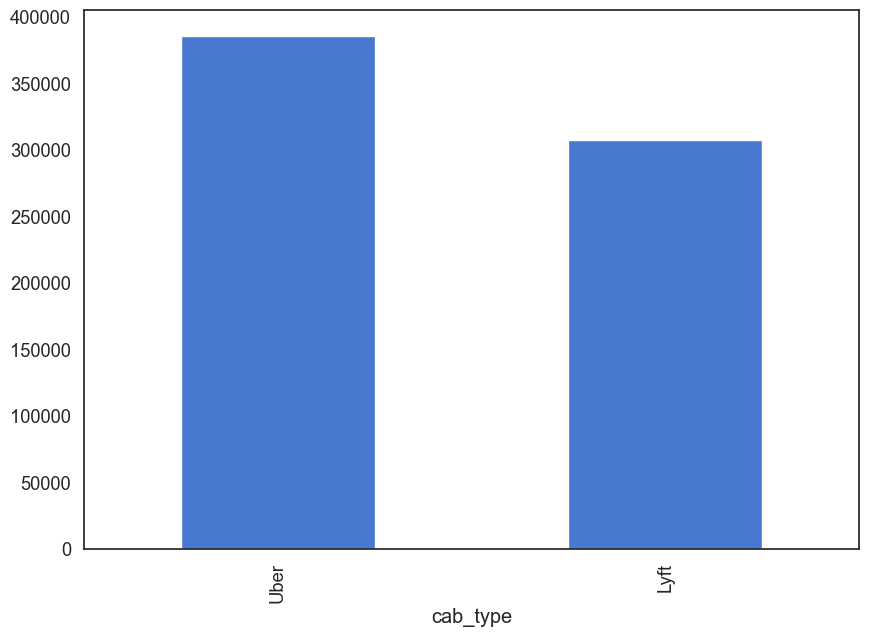

In [51]:
df.cab_type.value_counts().plot(kind="bar")

Note: Above states how many data points are Uber and how many data points are Lyft. As seen in the graph, there is a lot more data on Uber than on Lyft, which could cause our model to be more biased.

In [84]:
# Encode categorical variables
label_encoder = LabelEncoder()
df['cab_type'] = label_encoder.fit_transform(df['cab_type']) # Lyft = 0, Uber = 1

# Splitting Data
X = df.drop(columns=['cab_type'])
y = df['cab_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# unsqueeze() ensures the correct shape for a neural network output (a column vector)

In [54]:
# Define dataset
class RideshareDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = RideshareDataset(X_train_tensor, y_train_tensor)
test_dataset = RideshareDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [15]:
# Define the model
class Uber_vs_Lift(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Creating Layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # implement forward
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In the first two layers (fc1, and fc2) teh activation function ReLU is used for: 
- Prevents vanishing gradients, sparsity, and efficient computation.
- enables the network to model nonlinear relationships effectively.

In the last layer (fc3), you use sigmoid instead of ReLU because the task is binary classification. The sigmoid squashes the output to the range [0,1], representing a probability for the classes (Lyft or Uber).

Dropout is a technique where a random subset of neurons is "dropped" (outputs are set to zero) during each foward passing. In this case 30% (0.3).

Dropout prevents overfitting:
- neural networks with many parameters can overfit the training data

Why on the first layer?
- Dropout applied here prevents the network from excessively memorizing early-stage patterns, which could propagate overfitting through the network.

Dropout is disabled during testing/inference

In [55]:
# Instantiate model, loss, and optimizer
model = Uber_vs_Lift(input_size=X_train.shape[1]) # get the number of features
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BCELoss (Binary Cross-Entropy Loss):
Used for binary classification problems where the output represents probabilities for two classes.

This is best for this problem as we have two classes (Lyft vs Uber).

The output expectation assumes the output is a probability between 0 and 1, which is what sigmoid activation function uses (what is implemented in the last layer).

In [22]:
# Train
epochs = 20
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {e+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
# Evaluate model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        predicted = (predictions >= 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy: .2f}')
                

Epoch 1/20, Loss: 0.5383
Epoch 2/20, Loss: 0.5354
Epoch 3/20, Loss: 0.5362
Epoch 4/20, Loss: 0.5304
Epoch 5/20, Loss: 0.5329
Epoch 6/20, Loss: 0.5263
Epoch 7/20, Loss: 0.5220
Epoch 8/20, Loss: 0.5342
Epoch 9/20, Loss: 0.5401
Epoch 10/20, Loss: 0.5324
Epoch 11/20, Loss: 0.5368
Epoch 12/20, Loss: 0.5363
Epoch 13/20, Loss: 0.5351
Epoch 14/20, Loss: 0.5340
Epoch 15/20, Loss: 0.5312
Epoch 16/20, Loss: 0.5265
Epoch 17/20, Loss: 0.5356
Epoch 18/20, Loss: 0.5309
Epoch 19/20, Loss: 0.5350
Epoch 20/20, Loss: 0.5353
Test Accuracy:  0.66


In [36]:
# Set model to evaluation mode
model.eval()

# Prepare test data tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Disable gradient computation and run a forward pass
with torch.no_grad():
    output = model(X_test_tensor)

# Apply sigmoid threshold to get binary predictions (0 or 1)
predicted_class = (output > 0.5).float()

# Convert predictions to actual labels (Lyft or Uber)
predicted_labels = ['Lyft' if label == 0 else 'Uber' for label in predicted_class.squeeze().tolist()]

# Show first few predictions
print(predicted_labels[:10])

['Uber', 'Uber', 'Uber', 'Uber', 'Uber', 'Uber', 'Lyft', 'Uber', 'Uber', 'Lyft']


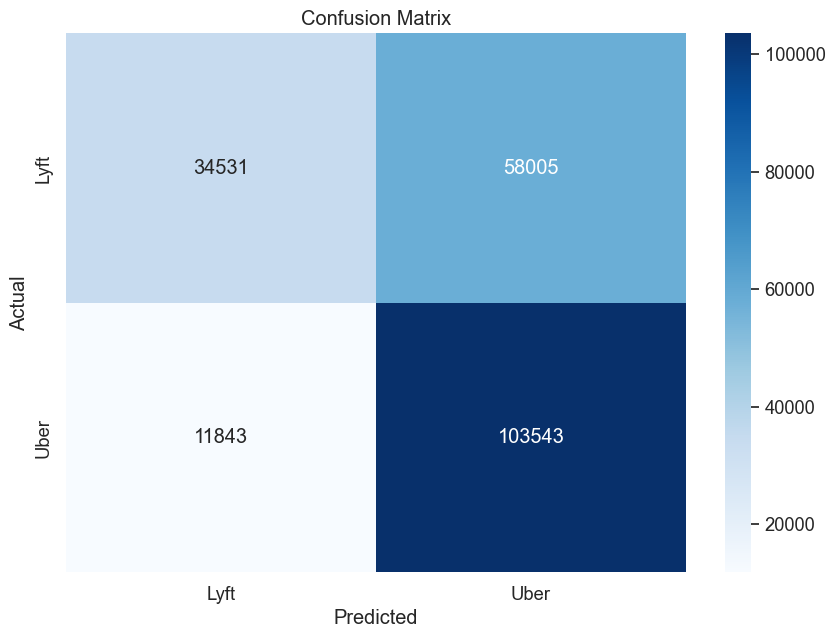

In [37]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_class.squeeze())

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Lyft', 'Uber'], yticklabels=['Lyft', 'Uber'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Next:   

In [75]:
# Create a new feature for distance to price ratio
df['distance_to_price_ratio'] = df['distance'] / df['price']

This new feature will give us an idea of how much distance is covered per unit of price.

In [76]:
df.head()

,price,distance,surge_multiplier,latitude,longitude,source,destination,hour,day,month,timestamp,temperature,humidity,precipProbability,windSpeed,cab_type,weekday,is_weekend,weather_condition,distance_to_price_ratio
101166,11.5,-0.684349,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,Uber,0,0,0,-0.059509
29811,8.5,-0.658009,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,Uber,0,0,0,-0.077413
221131,8.5,-0.693129,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,Uber,0,0,0,-0.081545
221132,4.5,-0.693129,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,Uber,0,0,0,-0.154029
471830,5.0,-0.640448,1.0,42.3398,-71.0892,0,2,4,26,11,1.543208e+09,0.287777,1.146373,0.0,-1.822062,Lyft,0,0,0,-0.128090


In [82]:
# Create a new column 'best_service' based on the distance-to-price ratio

# Sort by 'source', 'destination', 'timestamp' to group similar rides
df = df.sort_values(by=['source', 'destination', 'timestamp'])

# Group by similar conditions (source, destination, timestamp)
# Aggregate to find the best service for each group
def determine_best_service(group):
    # Assume each group has at most one ride per service
    if len(group) > 1:  # Compare Uber and Lyft
        best_row = group.loc[group['distance_to_price_ratio'].idxmax()]
        return best_row['cab_type']  # Return 'Uber' or 'Lyft'
    else:
        return group['cab_type'].iloc[0]  # Only one ride available

# Apply the grouping and determine the best service
# Calculate the best row index for each group
best_indices = (
    df.groupby(['source', 'destination', 'timestamp'])['distance_to_price_ratio']
    .transform('idxmax')
)

# Use these indices to assign the best service
df['best_service'] = df.loc[best_indices, 'cab_type'].values

# Convert 'best_service' to binary (0 for Lyft, 1 for Uber)
df['best_service'] = df['best_service'].apply(lambda x: 1 if x == 'Uber' else 0)


Labeling the Best Service Based on the Ratio: You can now use the distance-to-price ratio to determine which rideshare service offers the better value. For example:

If the ratio for Uber is higher than for Lyft, it means Uber gives more distance for the price, so Uber would be considered the better service for that ride.
Similarly, if Lyft has a higher ratio, it would be considered the better service.

In [85]:
# Split the data into features and target
y = df['best_service']  # Target is the 'best_service' column (0 or 1)
X = df.drop(columns=['best_service'])  # Drop target column from features


# Normalize the features (important for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Ensure it's a column vector

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [86]:
# Define the model
model = Uber_vs_Lift(X_train.shape[1])

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001

In [87]:
# Training the model
num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients
    # Forward pass
    outputs = model(X_train_tensor)
    # Compute the loss
    loss = criterion(outputs, y_train_tensor)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs for monitoring
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradient calculation for inference
    test_outputs = model(X_test_tensor)
    # Apply sigmoid threshold to get binary predictions (Uber: 1, Lyft: 0)
    predicted_labels = (test_outputs > 0.5).float()

# Convert predicted labels back to 'Uber' and 'Lyft' for interpretation
predicted_service = ['Uber' if label == 1 else 'Lyft' for label in predicted_labels.squeeze().tolist()]

# Calculate accuracy
accuracy = (predicted_labels.squeeze() == y_test_tensor.squeeze()).float().mean()
print(f"Accuracy on test data: {accuracy.item():.4f}")


Epoch [10/100], Loss: 0.6484
Epoch [20/100], Loss: 0.5976
Epoch [30/100], Loss: 0.5304
Epoch [40/100], Loss: 0.4477
Epoch [50/100], Loss: 0.3602
Epoch [60/100], Loss: 0.2840
Epoch [70/100], Loss: 0.2314
Epoch [80/100], Loss: 0.2030
Epoch [90/100], Loss: 0.1907
Epoch [100/100], Loss: 0.1856
Accuracy on test data: 0.9574


In [89]:
X.head()

,price,distance,surge_multiplier,latitude,longitude,source,destination,hour,day,month,timestamp,temperature,humidity,precipProbability,windSpeed,cab_type,weekday,is_weekend,weather_condition,distance_to_price_ratio
101166,11.5,-0.684349,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,1,0,0,0,-0.059509
29811,8.5,-0.658009,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,1,0,0,0,-0.077413
221131,8.5,-0.693129,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,1,0,0,0,-0.081545
221132,4.5,-0.693129,1.0,42.3398,-71.0892,0,2,4,26,11,1.543207e+09,0.287777,1.146373,0.0,-1.822062,1,0,0,0,-0.154029
471830,5.0,-0.640448,1.0,42.3398,-71.0892,0,2,4,26,11,1.543208e+09,0.287777,1.146373,0.0,-1.822062,0,0,0,0,-0.128090


In [93]:
X_test_df = pd.DataFrame(X_test, columns=['price', 'distance', 'surge_multiplier', 'latitude', 'longitude', 'source', 'destination', 'hour', 'day', 'month', 'timestamp', 'temperature', 'humidity', 'precipProbability', 'windSpeed', 'cab_type', 'weekday', 'is_weekend', 'weather_condition', 'distance_to_price_ratio'])
print(type(X_test))
print(type(X_test_df))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


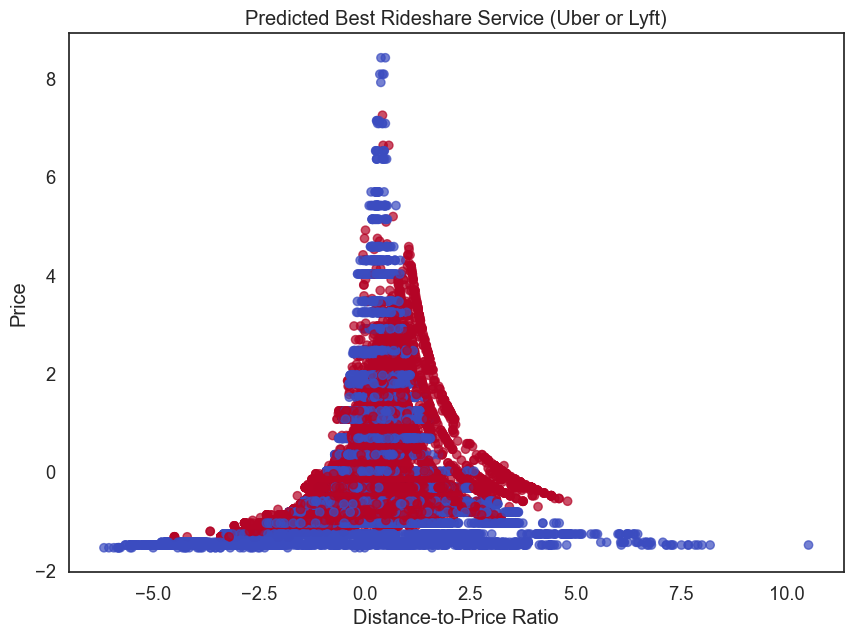

In [95]:
# Plot distance-to-price ratio vs price, colored by predicted service
plt.scatter(X_test_df['distance_to_price_ratio'], X_test_df['price'], c=predicted_labels.squeeze(), cmap='coolwarm', alpha=0.7)
plt.xlabel('Distance-to-Price Ratio')
plt.ylabel('Price')
plt.title('Predicted Best Rideshare Service (Uber or Lyft)')
plt.show()

Uber = Red
Lyft = Blue

A Higher distance to price Ratio means that for each unit of money spent a greater distance is covered by the ride.  In other words, you are getting more distance per unit of cost. 

In [102]:
y

101166    1
29811     1
221131    1
221132    1
471830    0
         ..
175530    1
175531    1
175532    1
175533    1
175534    1
Name: best_service, Length: 693071, dtype: int64

Out of all the rows in y, 0 is the most common for the best_service, meaning Lyft is the best ride share service to use according to this model and dataset.